In [13]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import networkx as nx

In [15]:
import pandas as pd
import networkx as nx

# Load GTFS files
stops = pd.read_csv("Data/NYC Data/Subway GTFS/gtfs_subway/stops.txt")           # Station data
stop_times = pd.read_csv("Data/NYC Data/Subway GTFS/gtfs_subway/stop_times.txt") # Stop sequences for trips
trips = pd.read_csv("Data/NYC Data/Subway GTFS/gtfs_subway/trips.txt")           # Trip information
routes = pd.read_csv("Data/NYC Data/Subway GTFS/gtfs_subway/routes.txt")         # Route information

# Step 1: Filter to subway-only routes
# 1 indicates subway in the route_type column of routes.txt
subway_routes = routes[routes['route_type'] == 1]
subway_trips = trips[trips['route_id'].isin(subway_routes['route_id'])]
subway_stop_ids = stop_times[stop_times['trip_id'].isin(subway_trips['trip_id'])]['stop_id'].unique()

# Step 2: Deduplicate stops to group platforms into single stations
if 'parent_station' in stops.columns:
    stops['station_id'] = stops['parent_station']
else:
    stops['station_id'] = stops['stop_name']  # Use stop_name as fallback

stations = stops[stops['stop_id'].isin(subway_stop_ids)].groupby('station_id').agg({
    'stop_name': 'first',
    'stop_lat': 'mean',
    'stop_lon': 'mean'
}).reset_index()

# Step 3: Initialize the graph
G = nx.Graph()

# Add nodes
for _, row in stations.iterrows():
    G.add_node(
        row['station_id'],
        name=row['stop_name'],
        latitude=row['stop_lat'],
        longitude=row['stop_lon']
    )

# Step 4: Generate edges
# Sort stop_times to create consecutive edges for trips
stop_times = stop_times[stop_times['trip_id'].isin(subway_trips['trip_id'])]  # Filter relevant trips
stop_times.sort_values(['trip_id', 'stop_sequence'], inplace=True)

# Create edges between consecutive stops in each trip
edges = []
for trip_id, trip_data in stop_times.groupby('trip_id'):
    stops_in_trip = trip_data['stop_id'].tolist()
    # Add edges between consecutive stops
    for i in range(len(stops_in_trip) - 1):
        source, target = stops_in_trip[i], stops_in_trip[i + 1]
        # Ensure edges use the deduplicated station_id
        source_station = stops.loc[stops['stop_id'] == source, 'station_id'].values[0]
        target_station = stops.loc[stops['stop_id'] == target, 'station_id'].values[0]
        if source_station != target_station:  # Avoid self-loops
            edges.append((source_station, target_station))

# Deduplicate edges
unique_edges = list(set(edges))
G.add_edges_from(unique_edges)

# Step 5: Visualize the graph
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph has 474 nodes and 543 edges.


In [17]:
G.nodes()

NodeView(('101', '103', '104', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '142', '201', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '301', '302', '401', '402', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '418', '419', '420', '423', '501', '502', '503', '504', '505', '601', '602', '603', '604', '606', '607', '608', '609', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '621', '622', '623', '624', '625', '626', '627', '62

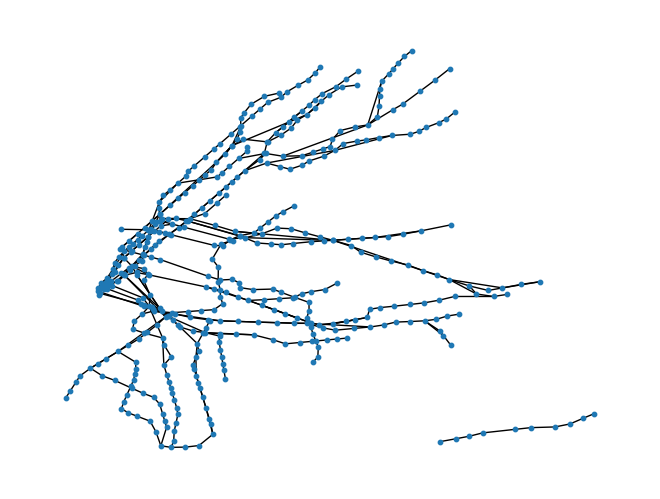

In [22]:
pos = {node: (data['longitude'], data['latitude']) for node, data in G.nodes(data=True)}
nx.draw(G, pos, with_labels=False, node_size=10)
plt.show()


In [29]:
G.edges('F03')

EdgeDataView([('F03', 'F01'), ('F03', 'F02'), ('F03', 'F04'), ('F03', 'F06')])

In [26]:
adj_net = pd.DataFrame(nx.adjacency_matrix(G))

In [20]:
adj_net

,0,1,2,3,4,5,6,7,8,9,...,464,465,466,467,468,469,470,471,472,473
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
472,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
